# Desafio 3

## Importación de librerías

In [45]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import device, keras
from tensorflow.config import list_physical_devices
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU, LayerNormalization, Attention
from keras.utils import to_categorical


from utils import *

Se verifica que la GPU esté disponible 

In [26]:
gpus = list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU detected. Using CPU instead.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Carga de datos

In [27]:
df = pd.read_csv('data/shakespeare.txt', sep='/n', header=None, engine='python')
df.head()

,0
0,THE SONNETS
1,1
2,"From fairest creatures we desire increase,"
3,"That thereby beauty’s rose might never die,"
4,"But as the riper should by time decease,"


In [28]:
print(f"Number of documents: {df.shape[0]}")

Number of documents: 153571


## Preprocesamiento de datos

Se convierten los datos a una lista de documentos

In [29]:
text = list(df[0])

print(f"Dcoument 10: {text[10]}")

Dcoument 10: Thou that art now the world’s fresh ornament,


Se segmenta el texto en palabras

In [30]:
segmented_sentences = [ text_to_word_sequence(sentence) for sentence in text ]

print(f"Segmented sentence 10: {segmented_sentences[10]}")

Segmented sentence 10: ['thou', 'that', 'art', 'now', 'the', 'world’s', 'fresh', 'ornament']


Se muestran la cantidad de palabras en el documento

In [31]:
length_sentences = [len(sentence) for sentence in segmented_sentences]

print("Number of words in the sentence 10: ", length_sentences[10])

Number of words in the sentence 10:  8


Show a distribution of the sentences length

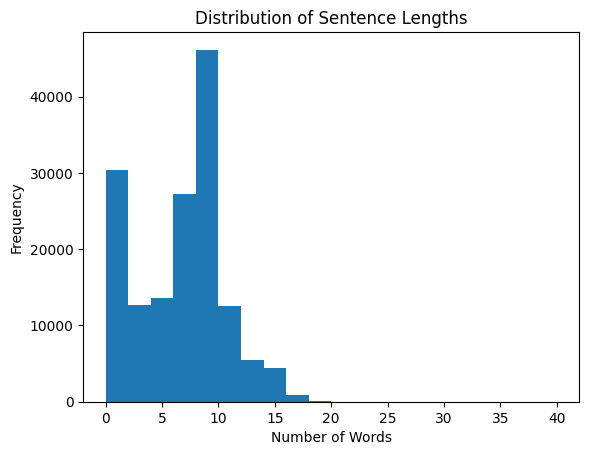

In [32]:
plt.hist(length_sentences, bins=20, range=(0, 40))
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

Se calcula el tamaño del contexto máximo basado en el percentil 90 de las longitudes de las oraciones

In [33]:
max_context_size = int(np.percentile(length_sentences, 90) - 1)
print(f'max_context_size: {max_context_size}')

max_context_size: 9


Se entrena el tokenizador y se obtienen las oraciones tokenizadas

In [34]:
tok = Tokenizer()
# Train the tokenizer
tok.fit_on_texts(segmented_sentences)
# Convert the text to sequences
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

## Iteración 1

Se divide el conjunto de datos en entrenamiento y validación

In [12]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Se aplica padding a las oraciones para que todas tengan la misma longitud

In [13]:
train_sequences = pad_and_concatenate_sentences(tokenized_sentences_train, max_context_size)
val_sequences = pad_and_concatenate_sentences(tokenized_sentences_val, max_context_size)
print(f"train_sequences shape: {train_sequences.shape}")
print(f"val_sequences shape: {val_sequences.shape}")

train_sequences shape: (652176, 10)
val_sequences shape: (163455, 10)


Se definen las variables de entrada y salida

In [14]:
X_train = train_sequences[:,:-1]
X_val = val_sequences[:,:-1]
y_train = train_sequences[:,-1]
y_val = val_sequences[:,-1]

Se calcula el tamaño del vocabulario

In [15]:
vocab_size = len(tok.word_counts)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 29849


In [85]:
# Ensure GPU usage
with device(device_name='GPU:0'):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=vocab_size+1, output_dim=300, input_shape=(max_context_size,)))
    model.add(Dropout(0.3))

    # First Bidirectional LSTM layer with L2 regularization and dropout
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.2))

    # Second Bidirectional LSTM layer with L2 regularization and dropout
    model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.001))))
    model.add(Dropout(0.2))

    # Output layer with softmax for classification
    model.add(Dense(vocab_size+1, activation='softmax'))

    # Adam optimizer with learning rate 1e-4
    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    
    # Compile the model with sparse categorical crossentropy and metrics including perplexity
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy', perplexity])

    # Print the summary of the model
    model.summary()
    
    # Early stopping and checkpointing
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/home/chris/Documents/desafios_nlp/venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 9, 300)         │     8,955,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 9, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 9, 256)         │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 29850)          │     7,671,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,459,986 (66.60 MB)

 Trainable params: 17,459,986 (66.60 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50, 
    batch_size=64, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


10191/10191 ━━━━━━━━━━━━━━━━━━━━ 215s 21ms/step - accuracy: 0.0438 - loss: 7.0500 - perplexity: 1483.6213 - val_accuracy: 0.0759 - val_loss: 6.5108 - val_perplexity: 701.5793 - learning_rate: 0.0010
Epoch 2/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 210s 21ms/step - accuracy: 0.0795 - loss: 6.4098 - perplexity: 625.9964 - val_accuracy: 0.0910 - val_loss: 6.3686 - val_perplexity: 596.3594 - learning_rate: 9.5000e-04
Epoch 3/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 210s 21ms/step - accuracy: 0.0939 - loss: 6.2202 - perplexity: 513.3427 - val_accuracy: 0.0973 - val_loss: 6.2739 - val_perplexity: 536.8776 - learning_rate: 9.0250e-04
Epoch 4/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 210s 21ms/step - accuracy: 0.1020 - loss: 6.1016 - perplexity: 453.1288 - val_accuracy: 0.1006 - val_loss: 6.2341 - val_perplexity: 512.0422 - learning_rate: 8.5737e-04
Epoch 5/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 209s 20ms/step - accuracy: 0.1066 - loss: 6.0123 - perplexity: 412.5701 - val_accuracy: 0.1037 - val_loss: 6.1997 - va

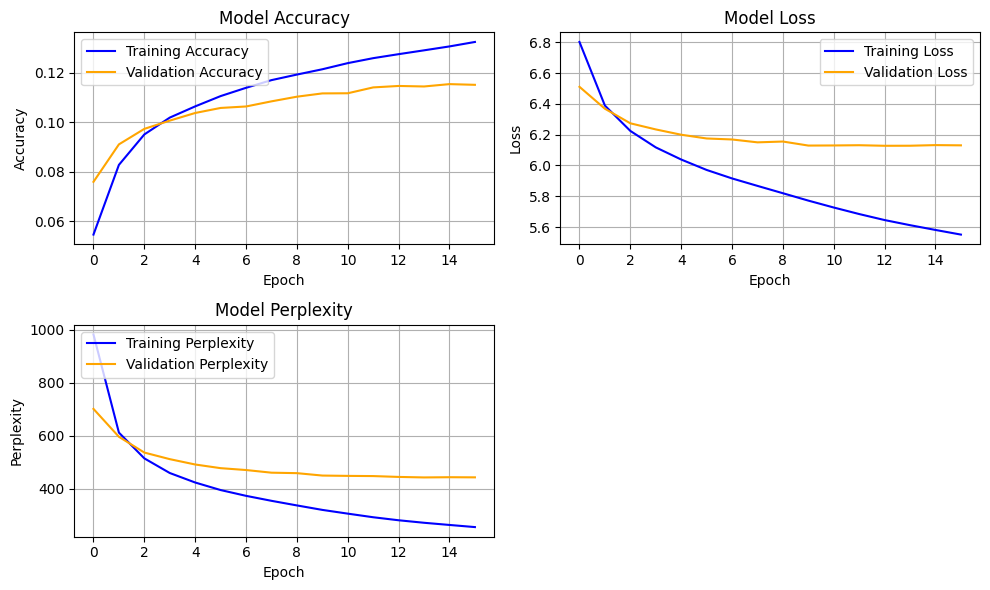

In [87]:
# Create a grid of plots, excluding the learning rate schedule
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Plot accuracy on the top left
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid()

# Plot loss and val_loss on the top right, sharing a single plot
axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid()

# Plot perplexity on the bottom left
axes[1, 0].plot(history.history['perplexity'], label='Training Perplexity', color='blue')
axes[1, 0].plot(history.history['val_perplexity'], label='Validation Perplexity', color='orange')
axes[1, 0].set_title('Model Perplexity')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Perplexity')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid()

# Remove the empty plot (bottom right)
fig.delaxes(axes[1, 1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [100]:
seed_text = "Shall I compare thee to a summer's day?"

generate_seq(model, tok, seed_text, max_length=max_context_size, n_words=12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


"Shall I compare thee to a summer's day? and i will not be a man of the king of england"

In [97]:
seed_text = "When in disgrace with fortune and men's eyes"

generate_seq(model, tok, seed_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


"When in disgrace with fortune and men's eyes of the world and all the king is a man"

In [92]:
seed_text = "Once upon a time in a land far away"

generate_seq(model, tok, seed_text, max_length=max_context_size, n_words=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Once upon a time in a land far away with him'

Las oraciones generadas por el modelo tienen cierta coherencia semántica. Sin embargo, el modelo no es capaz de generar oraciones que tengan sentido completo. Muestra cierta preferencia por palabras que aparecen con mayor frecuencia como podrían ser: `king`, `man`; lo cual tiene sentido, ya que pueden ser palabras que aparecen con mayor frecuencia en las obras de Shakespeare.

## Iteración 2

In [35]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [36]:
max_context_size = 35

In [37]:
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences)
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [38]:
train_sequences = pad_and_concatenate_sentences(tokenized_sentences_train, max_context_size)
val_sequences = pad_and_concatenate_sentences(tokenized_sentences_val, max_context_size)
print(f"train_sequences shape: {train_sequences.shape}")
print(f"val_sequences shape: {val_sequences.shape}")

train_sequences shape: (652176, 36)
val_sequences shape: (163455, 36)


In [39]:
X_train = train_sequences[:,:-1]
X_val = val_sequences[:,:-1]
y_train = train_sequences[:,-1]
y_val = val_sequences[:,-1]

In [40]:
vocab_size = len(tok.word_counts)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 29849


In [56]:
# Ensure GPU usage
with device(device_name='GPU:0'):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=vocab_size+1, output_dim=300, input_shape=(max_context_size,)))
    model.add(Dropout(0.35))

    # First Bidirectional LSTM layer with L2 regularization and dropout
    model.add(Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))))
    model.add(LayerNormalization())
    model.add(Dropout(0.25))

    # Second Bidirectional LSTM layer with L2 regularization and dropout
    model.add(Bidirectional(LSTM(256, kernel_regularizer=l2(0.01))))
    model.add(LayerNormalization())
    model.add(Dropout(0.25))

    # Output layer with softmax for classification
    model.add(Dense(vocab_size+1, activation='softmax'))

    # Adam optimizer with learning rate 1e-4
    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    
    # Compile the model with sparse categorical crossentropy and metrics including perplexity
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy', perplexity])

    # Print the summary of the model
    model.summary()
    
    # Early stopping and checkpointing
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/home/chris/Documents/desafios_nlp/venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 35, 300)        │     8,955,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 35, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 35, 512)        │     1,140,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_19          │ (None, 35, 512)        │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 35, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 512)            │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 512)            │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29850)          │    15,313,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,985,746 (102.94 MB)

 Trainable params: 26,985,746 (102.94 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50, 
    batch_size=64, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


2024-10-15 22:22:03.102095: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


10191/10191 ━━━━━━━━━━━━━━━━━━━━ 330s 32ms/step - accuracy: 0.0299 - loss: 7.6080 - perplexity: 1630.3955 - val_accuracy: 0.0538 - val_loss: 6.7905 - val_perplexity: 923.7852 - learning_rate: 0.0010
Epoch 2/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 322s 32ms/step - accuracy: 0.0661 - loss: 6.6530 - perplexity: 769.0314 - val_accuracy: 0.0802 - val_loss: 6.4978 - val_perplexity: 680.7430 - learning_rate: 9.5000e-04
Epoch 3/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 323s 32ms/step - accuracy: 0.0820 - loss: 6.4135 - perplexity: 620.1579 - val_accuracy: 0.0881 - val_loss: 6.4978 - val_perplexity: 633.7930 - learning_rate: 9.0250e-04
Epoch 4/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 320s 31ms/step - accuracy: 0.0899 - loss: 6.3078 - perplexity: 552.5060 - val_accuracy: 0.0933 - val_loss: 6.3718 - val_perplexity: 584.6758 - learning_rate: 8.5737e-04
Epoch 5/50
10191/10191 ━━━━━━━━━━━━━━━━━━━━ 323s 32ms/step - accuracy: 0.0950 - loss: 6.2376 - perplexity: 518.8782 - val_accuracy: 0.0954 - val_loss: 6.3558 - va

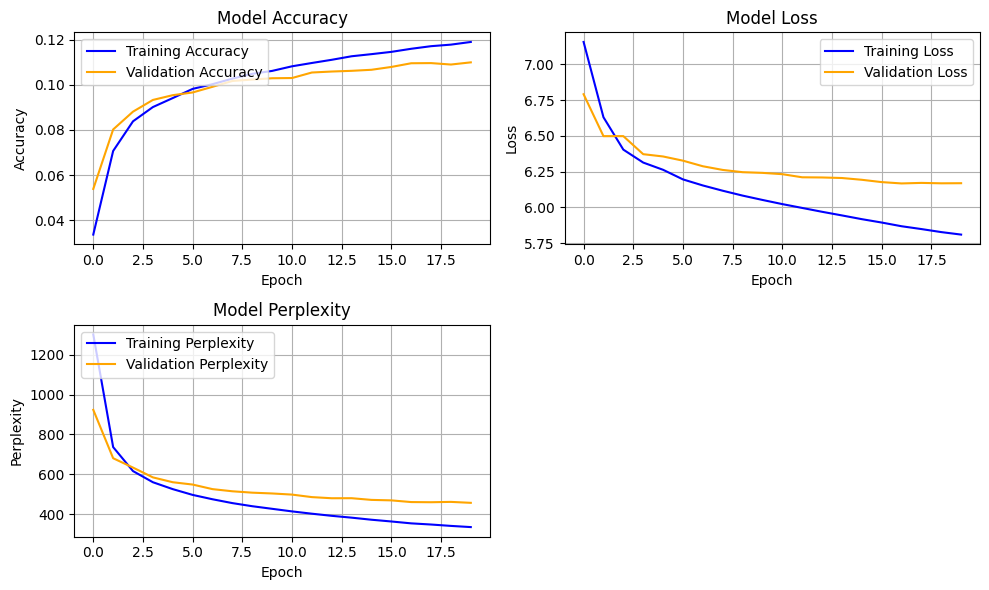

In [58]:
# Create a grid of plots, excluding the learning rate schedule
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Plot accuracy on the top left
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid()

# Plot loss and val_loss on the top right, sharing a single plot
axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid()

# Plot perplexity on the bottom left
axes[1, 0].plot(history.history['perplexity'], label='Training Perplexity', color='blue')
axes[1, 0].plot(history.history['val_perplexity'], label='Validation Perplexity', color='orange')
axes[1, 0].set_title('Model Perplexity')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Perplexity')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid()

# Remove the empty plot (bottom right)
fig.delaxes(axes[1, 1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Se puede ver en las gráficas que el entrenamiento del modelo se realizó en 20 épocas, y no se llego a entrar en una fase de sobreajuste.

In [64]:
seed_text = "Shall I compare thee to a summer's day?"

generate_seq(model, tok, seed_text, max_length=max_context_size, n_words=8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


"Shall I compare thee to a summer's day? of love and the king of the world"

In [66]:
seed_text = "When in disgrace with fortune and men's eyes"

generate_seq(model, tok, seed_text, max_length=max_context_size, n_words=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


"When in disgrace with fortune and men's eyes and the king of the world"

In [71]:
seed_text = "Once upon a time in a land far away"

generate_seq(model, tok, seed_text, max_length=max_context_size, n_words=11)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'Once upon a time in a land far away to the king of england and the king of the world'

La coherecia semántica de las oraciones generadas por el modelo ha empeorado, y se pueden ver oraciones que no tienen sentido completo. Además, en este caso, el modelo muestra mayor preferencia por sentencias como: `king of the`, mientras palabras se generen, estas se comenzarán a repetir.